# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

<br>
## Beta Version for Hurricane Matthew Tuning


<br>

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.integrate import simps

import pydotplus
from IPython import display
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
from scipy.stats import gaussian_kde as PDF

import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


**---**

## 1.0 Open a datasets


### 1.1- Load Hurricane Matthew Training Data (Buoy 42059 close to the path)

<br>

In [2]:
# Open data sets:
# --------------

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Open the data files
for i in range(5,10):
    file_name = 'datasets/42059/42059' + str(i+1) + '2016.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = date_range , infer_datetime_format = True)
    data_dic['df_' + str(i + 1)] = inter.iloc[:,1:]

# Sanity check    
data_dic['df_10'].head(10)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,83,8.6,10.8,99.00,99.00,99.0,999,1009.4,29.0,29.2,25.1,99.0,99.0
1,81,8.2,11.0,99.00,99.00,99.0,999,1009.5,29.0,29.2,25.5,99.0,99.0
2,80,8.4,11.0,99.00,99.00,99.0,999,1009.4,29.0,29.2,25.5,99.0,99.0
3,82,9.0,11.5,99.00,99.00,99.0,999,1009.5,29.0,29.2,24.8,99.0,99.0
4,86,8.9,11.6,2.66,8.33,6.4,93,1009.5,29.2,29.2,24.8,99.0,99.0
5,81,8.7,11.2,99.00,99.00,99.0,999,1009.6,29.1,29.2,25.1,99.0,99.0
6,79,9.3,11.4,99.00,99.00,99.0,999,1009.6,29.1,29.2,24.8,99.0,99.0
7,76,8.7,10.7,99.00,99.00,99.0,999,1009.6,29.1,29.2,25.1,99.0,99.0
8,77,9.1,11.7,99.00,99.00,99.0,999,1009.7,29.0,29.2,25.0,99.0,99.0
9,80,9.2,11.7,99.00,99.00,99.0,999,1009.7,29.0,29.2,25.1,99.0,99.0


### 1.2 Concate Data

In [3]:
# Concatenate all files:
# ---------------------

# initiation
df_global_raw = data_dic['df_6']

title = ['WSPD' , 'GST' , 'PRES' , 'ATMP']

for i in range(2,6):
    df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i + 5)]] , axis = 0)
    
df_global = df_global_raw[title]

# data array
data_raw = df_global.values

### 1.3 Remove defective data

In [4]:
# Preprocessing
# -------------

# determine defected rows
defect = []

# itterrate
for i in range (data_raw.shape[0]):
    if data_raw[i,-1] > 200.:
        defect.append(i)

# remove rows
data_clean = np.delete(data_raw, defect, axis = 0)

## 2.0- Simulated Data (White Noise)

<br>
This simulated data is used for benchmark to validate the model executtion and helps as a debugger. Not part of the analysis

<br>

In [5]:
# simulated Data
# --------------

d1 = np.random.normal(0. , 0.5 , (3000 , 2))
d2 = np.random.normal(0. , 0.9 , (500 , 2))
d3 = np.random.normal(0. , 0.5 , (3000 , 2))

sim_data1 = np.concatenate((d1, d2) , axis = 0)
sim_data = np.concatenate((sim_data1 , d3), axis = 0)

## 3.0 General Functions

<br>

### 3.1- Power Martingale with defined Epsilon

<br>

In [6]:
# Function to calculate Power Martingale - Single:
# ----------------------------------------------
# power_martingale function
# Description: Calculates Power Martingale for single epsilon
# Input:
#       data - numpy matrix containing the training data set
#       eps - epsilon value
#       delay - 
#       sim - 
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def power_martingale(data , eps , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))
    
    # Initiate difference multiplier
    diff = 1.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        # diff_arr[i] = np.log( np.absolute(diff * (delta - 1.)) )
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

In [7]:
# Function to calculate Power Martingale - array:
# ----------------------------------------------
# power_martingale_arr function
# Description: Calculates Power Martingale Array
# Input:
#       data - numpy matrix containing the data set
#       eps - epsilon value
#       delay - 
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
def power_martingale_arr(data , eps , delay):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # size of epsilons
    n_eps = eps.shape[0]
    
    # reshape the epsilons
    eps_r = eps.reshape((1,n_eps))
    
    # initiate Power Martingale
    power_mart = np.zeros((L , n_eps))

    # dummy multiplier
    M = np.zeros(eps_r.shape)
    
    # initiate difference measure
    diff_arr = np.zeros((L , n_eps))
    
    # Initiate difference multiplier
    diff = np.ones((L , n_eps))

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

### 3.2- Power Martingale with Mixture

<br>

In [8]:
# Function to calculate Power Martingale:
# ---------------------------------------
# power_martingale function
# Description: Calculates Power Martingale with mixture
# Input:
#       data - numpy matrix containing the training data set
#       res - Resolution of the uniform distribution for integrating epsilon values.
#       delay - 
#       sim - 
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def power_martingale_mix(data , res , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
    
        # Calculate delta Array    
        delta = np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Integrate for mix
        delta_mix = simps(delta , eps)
        
        # update power martingale
        M += delta_mix
        
        # Array
        power_mart[i] = M
        
        # difference
        diff_arr[i] = np.absolute(delta_mix)
        
        
    return power_mart , diff_arr

### 3.3- Support Functions

<br>

In [9]:
# Exponential Smoother:
# ---------------------
# smooth function
# Description: Exponential Smoother
# Input:
#       y - Data to be smoothed
#       alpha - alpha parameter
# Return:
#       x - smoothed values
def smooth(y , alpha):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Data size
    L = y.shape[0]
    
    # intiation
    x[0] = 0.5 * (1. + alpha) * y[0]
    
    # Iterrate for new samples
    for i in range(1,L):
        x[i] = alpha * y[i] + (1. - alpha) * x[i - 1]
        
    return x

In [10]:
# Function to generate a heatmap array for raw and smoothed signal
# ----------------------------------------------------------------
# heatmap_fil function
# Description: Exponential Smoother
# Input:
#       x - Data 
#       alpha - alpha parameter
# Return:
#       x - smoothed values
def heatmap_fil(x , alpha):
    
    # signal length
    L = x.shape[0]
    
    # apply smoothing
    xk = smooth(x , alpha)
    
    # reshape arrays
    x1 = xk.reshape((1,L)) / np.max(xk)
    x2 = x.reshape((1,L)) / np.max(x)
    
    # Augment arrays
    big1 = np.concatenate((x1 , x1) , axis = 0)
    big2 = np.concatenate((x2 , x2) , axis = 0)
    
    # Join arrays
    big = np.concatenate((big1 , big2) , axis = 0)
    
    return big
        


In [11]:
# get_name function
# Description: Gets the acronym definition of a column
# Input:
#       acronym - acronym value 
# Return:
#       str - acronym name
def get_name(acronym):
    values = {
     'WDIR' : 'Wind Direction',
     'WSPD' : 'Wind Speed',
     'GST' : 'Gust Speed',
     'WVHT' : 'Wave Height',
     'DPD' : 'Dominant Wave Period',
     'APD' : 'Average Wave Period',
     'MWD' : 'DPD Direction',
     'PRES' : 'Sea Level Pressure',
     'ATMP' : 'Air Temperature',
     'WTMP' : 'Sea Surface Temperature',
     'DEWP' : 'Dewpoint Temperature',
     'VIS' : 'Station Visibility',
     'TIDE' : 'Water Level'
    }
    return values[acronym]

## 4.0 Model Tuning


### 4.1- General Constants

In [12]:
# Selected epsilon array
e_array = np.linspace(0.01,0.99,100)

# selected delay array
delay_array = np.array(range(1,501))

# Dimensions
rows = len(delay_array)
cols = len(e_array)

# Resolution for mixture integral
resolution = 200

# Smoothing factor for change detection
a = 0.008

# Data size
L = data_clean.shape[0]

# Color map 
clr = plt.get_cmap('jet')

### 4.2- Power Martingale with variable Epsilon

<br>

In [13]:
# Tune for e and delay:
#----------------------

# Initiation of measure array
measure_pwr = np.zeros((rows, cols))

# timer initiation
timer_1 = 0.

for i in range(rows):
    
    # start timer
    start_1 = time.time()
    
    # specify delay
    de = int(delay_array[i])
        
    # specify epsilon
    e = e_array
    display.clear_output(wait=True)
    display.display('processing step ' + str(i + 1) + ' for delay ' + str(de), 
                    'Process time for previous step : ' + str(timer_1) + ' sec')
        
    # evaluate the difference
    pmar, dif = power_martingale_arr(data_clean, e , de)
    dif_s = smooth(dif , a)
        
    # maximum at Matthew
    dif_max_m = np.max(dif_s[17000:18000] , axis = 0) 
        
    # Put in measure array
    measure_pwr[i] = (dif_max_m - np.average(dif_s , axis = 0)) / dif_s.std(axis=0)
        
    # timer end
    timer_1 = time.time() - start_1

##                   

'processing step 500 for delay 500'

'Process time for previous step : 4.45477199554 sec'

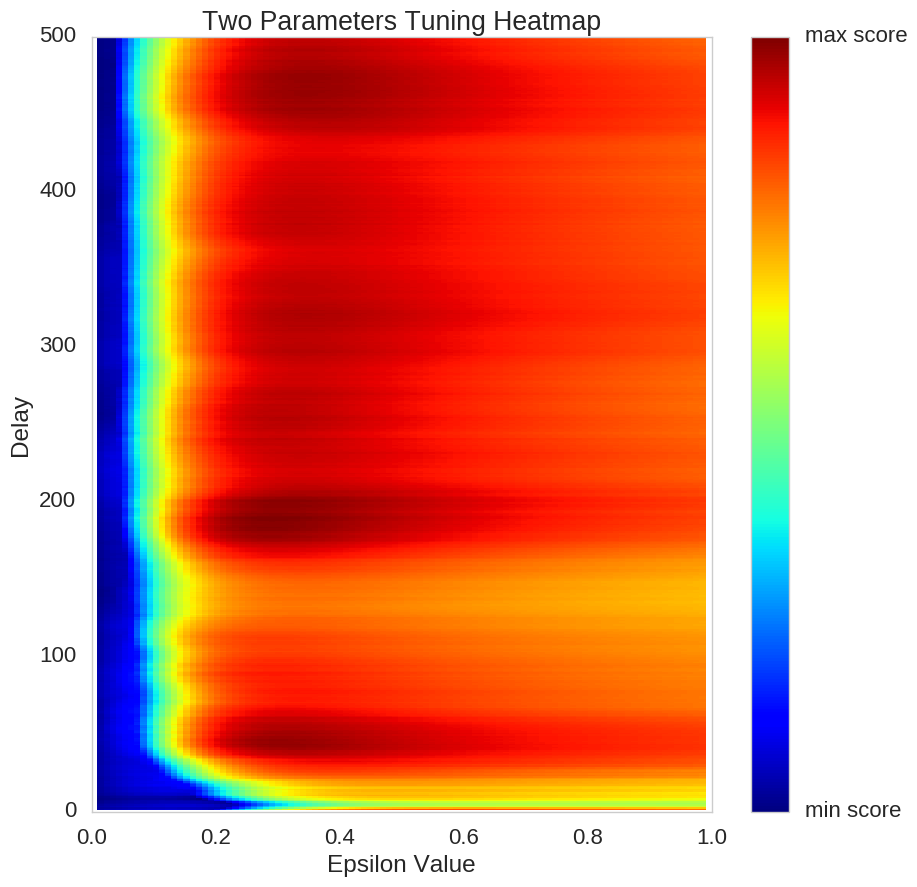

In [14]:
# Visualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
cax = ax.pcolor(e_array , delay_array, measure_pwr , cmap = clr)
cbar = fig.colorbar(cax , ticks = [measure_pwr.min() , measure_pwr.max()])
cbar.ax.set_yticklabels(['min score' , 'max score'])
ax.set_title('Two Parameters Tuning Heatmap')
ax.set_ylabel('Delay')
ax.set_xlabel('Epsilon Value')

plt.show()

In [15]:
# Best Values
# -----------

best_row = int(np.argmax(measure_pwr) / cols)
best_col = np.argmax(measure_pwr) - best_row * cols

best_de_pwr = int(delay_array[best_row])
best_e_pwr  = e_array[best_col]

print '\nBest Delay is : ' , best_de_pwr
print 'Best Epsilon Value is : ' , best_e_pwr


Best Delay is :  189
Best Epsilon Value is :  0.287171717172


In [16]:
# Application and Visualization(Power Martingale)
# ----------------------------------------------

# simulated data 
p_mar1_pwr , diff1_pwr = power_martingale(sim_data,best_e_pwr , best_de_pwr , sim = True)

# Filtered data
p_mar2_pwr, diff2_pwr = power_martingale(data_clean,best_e_pwr , best_de_pwr)

##

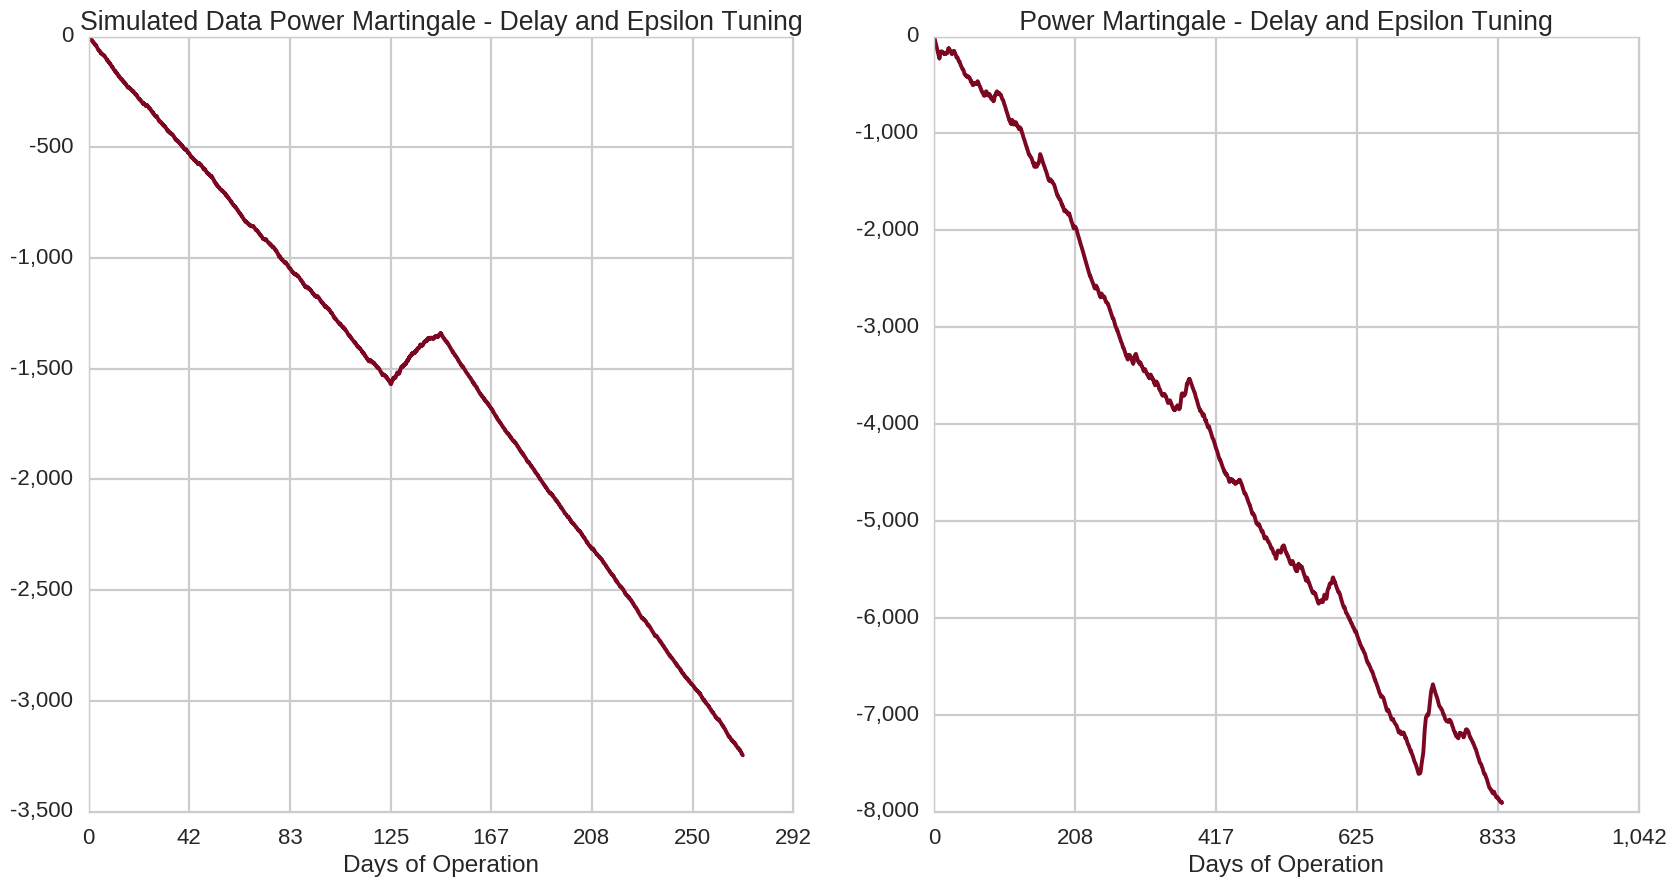

In [17]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (20,10))

# Simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_pwr)
ax1.set_title('Simulated Data Power Martingale - Delay and Epsilon Tuning')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2_pwr)
ax2.set_title(' Power Martingale - Delay and Epsilon Tuning ')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


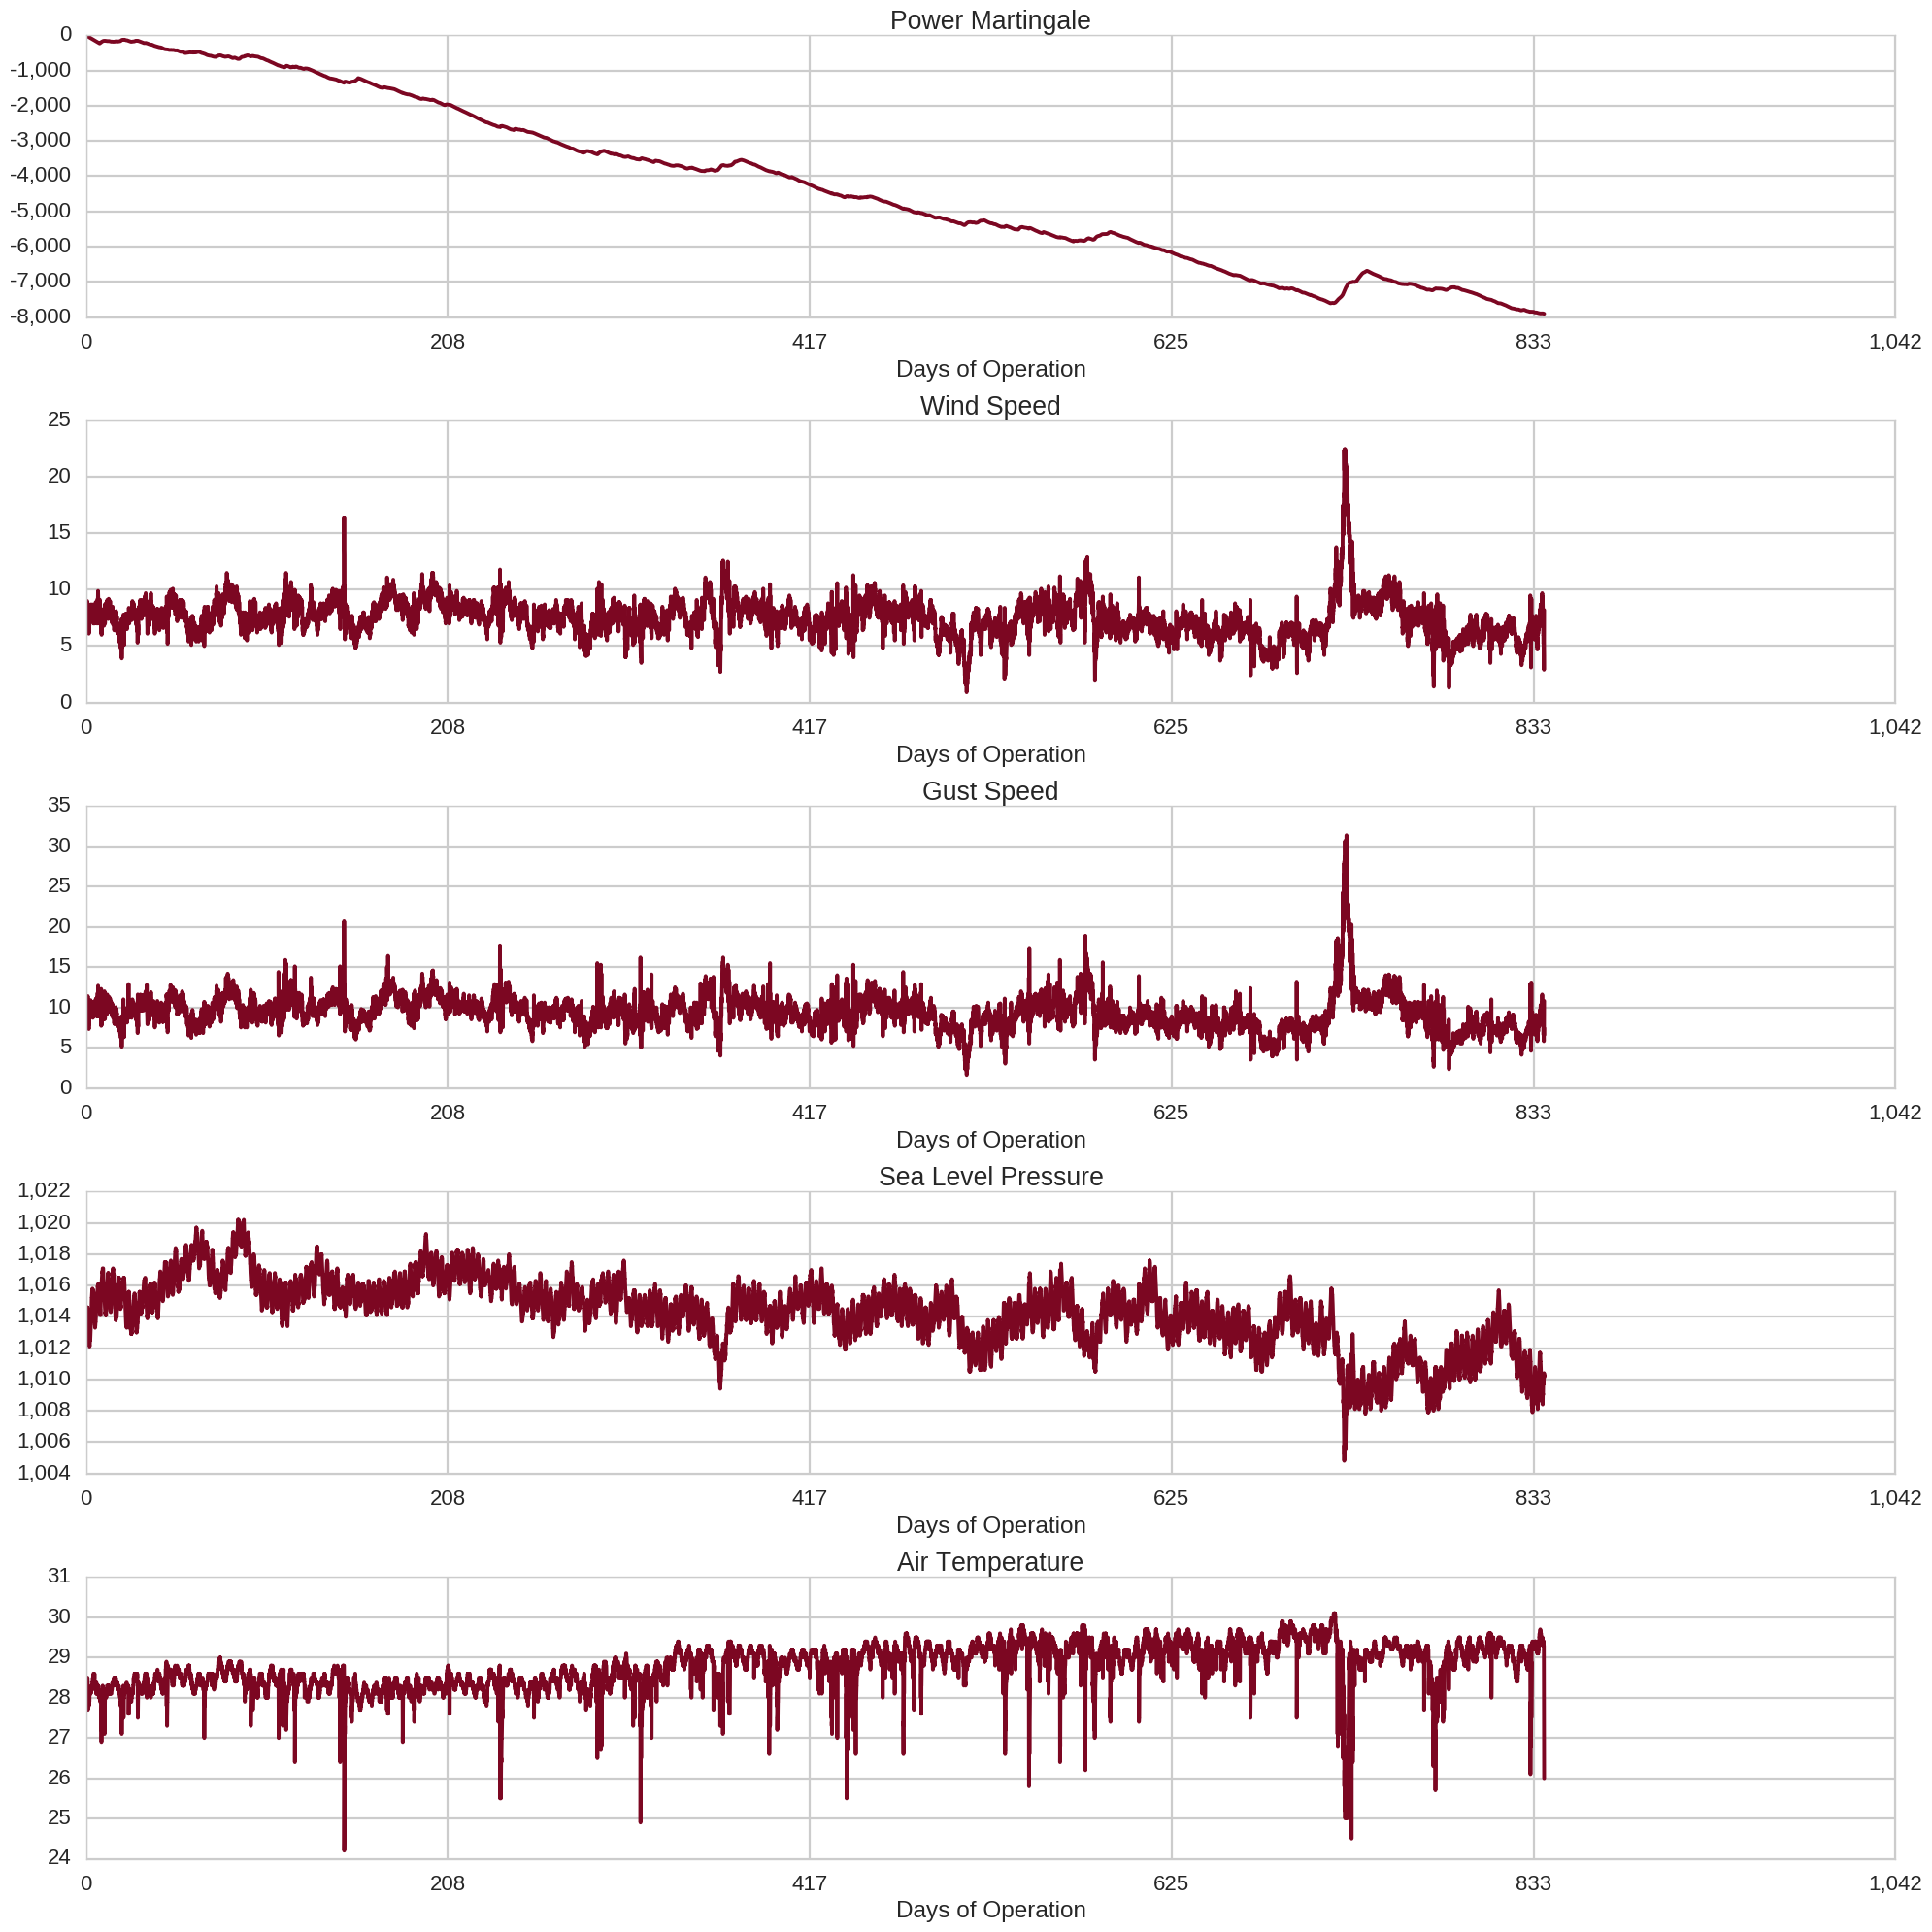

In [18]:
# Visualize the Power Martingale:
# ------------------------------
fig = plt.figure(figsize = (20,20))

# number of subplots
nsp = data_clean.shape[1]

# Martingale
ax1 = fig.add_subplot(nsp+1 , 1 , 1)
ax1.plot(p_mar2_pwr)
ax1.set_title('Power Martingale')
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

for i in range(nsp):
    ax = fig.add_subplot(nsp + 1, 1, i + 2)
    ax.plot(data_clean[:,i])
    ax.set_title(get_name(title[i]))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
    
plt.tight_layout()
plt.show()

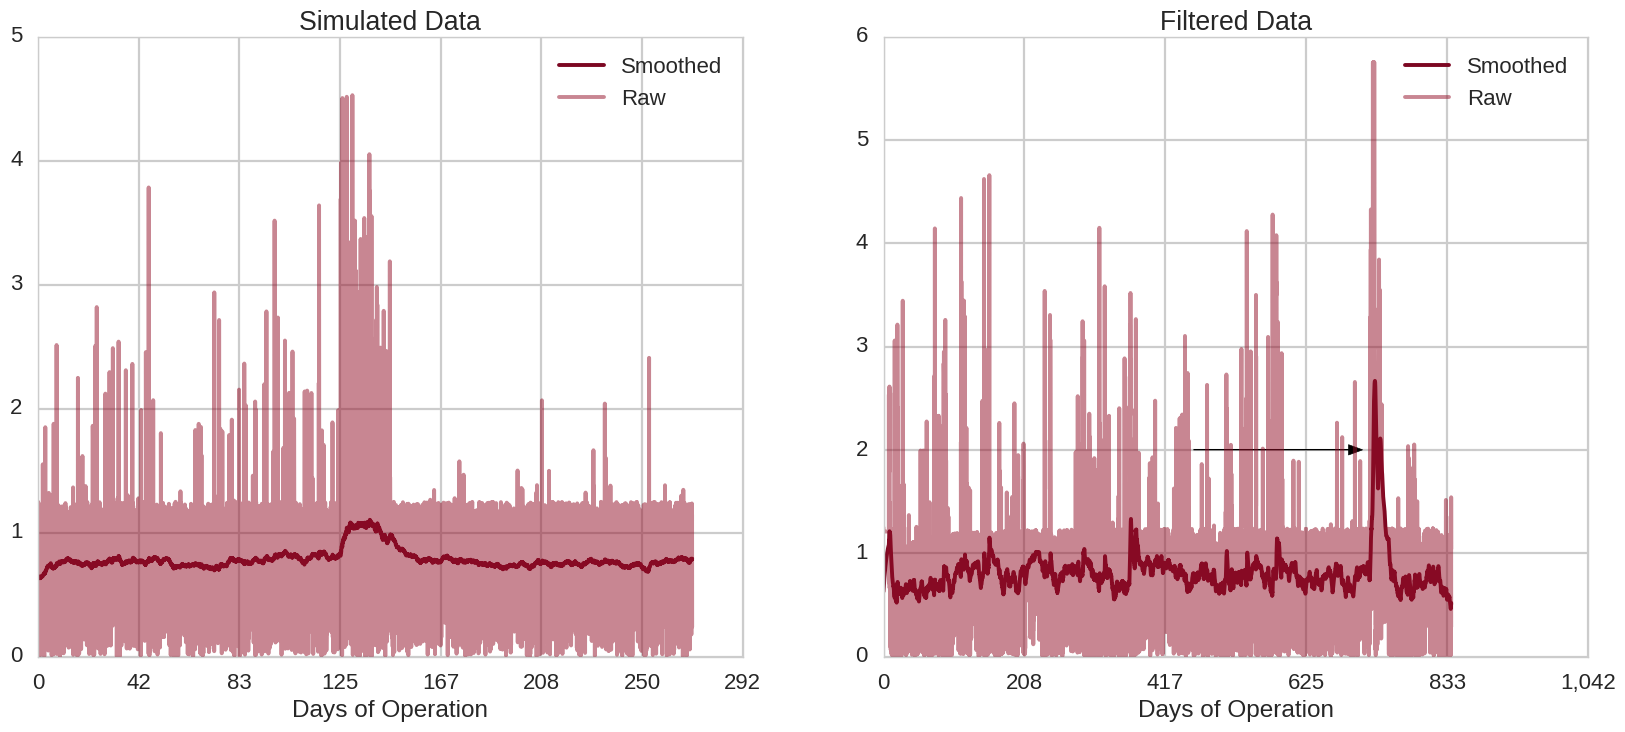

In [19]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,8))

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1_pwr , a) , label= 'Smoothed')
ax1.plot(diff1_pwr , alpha = 0.5, label = 'Raw')
ax1.set_title('Simulated Data')
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2_pwr , a) , label = 'Smoothed' )
ax2.plot(diff2_pwr , alpha = 0.5 , label = 'Raw')
ax2.set_title('Filtered Data')
ax2.arrow(11000,2,5500,0, head_width=0.1, head_length=500, fc='k', ec='k')
ax2.legend()
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

plt.show()

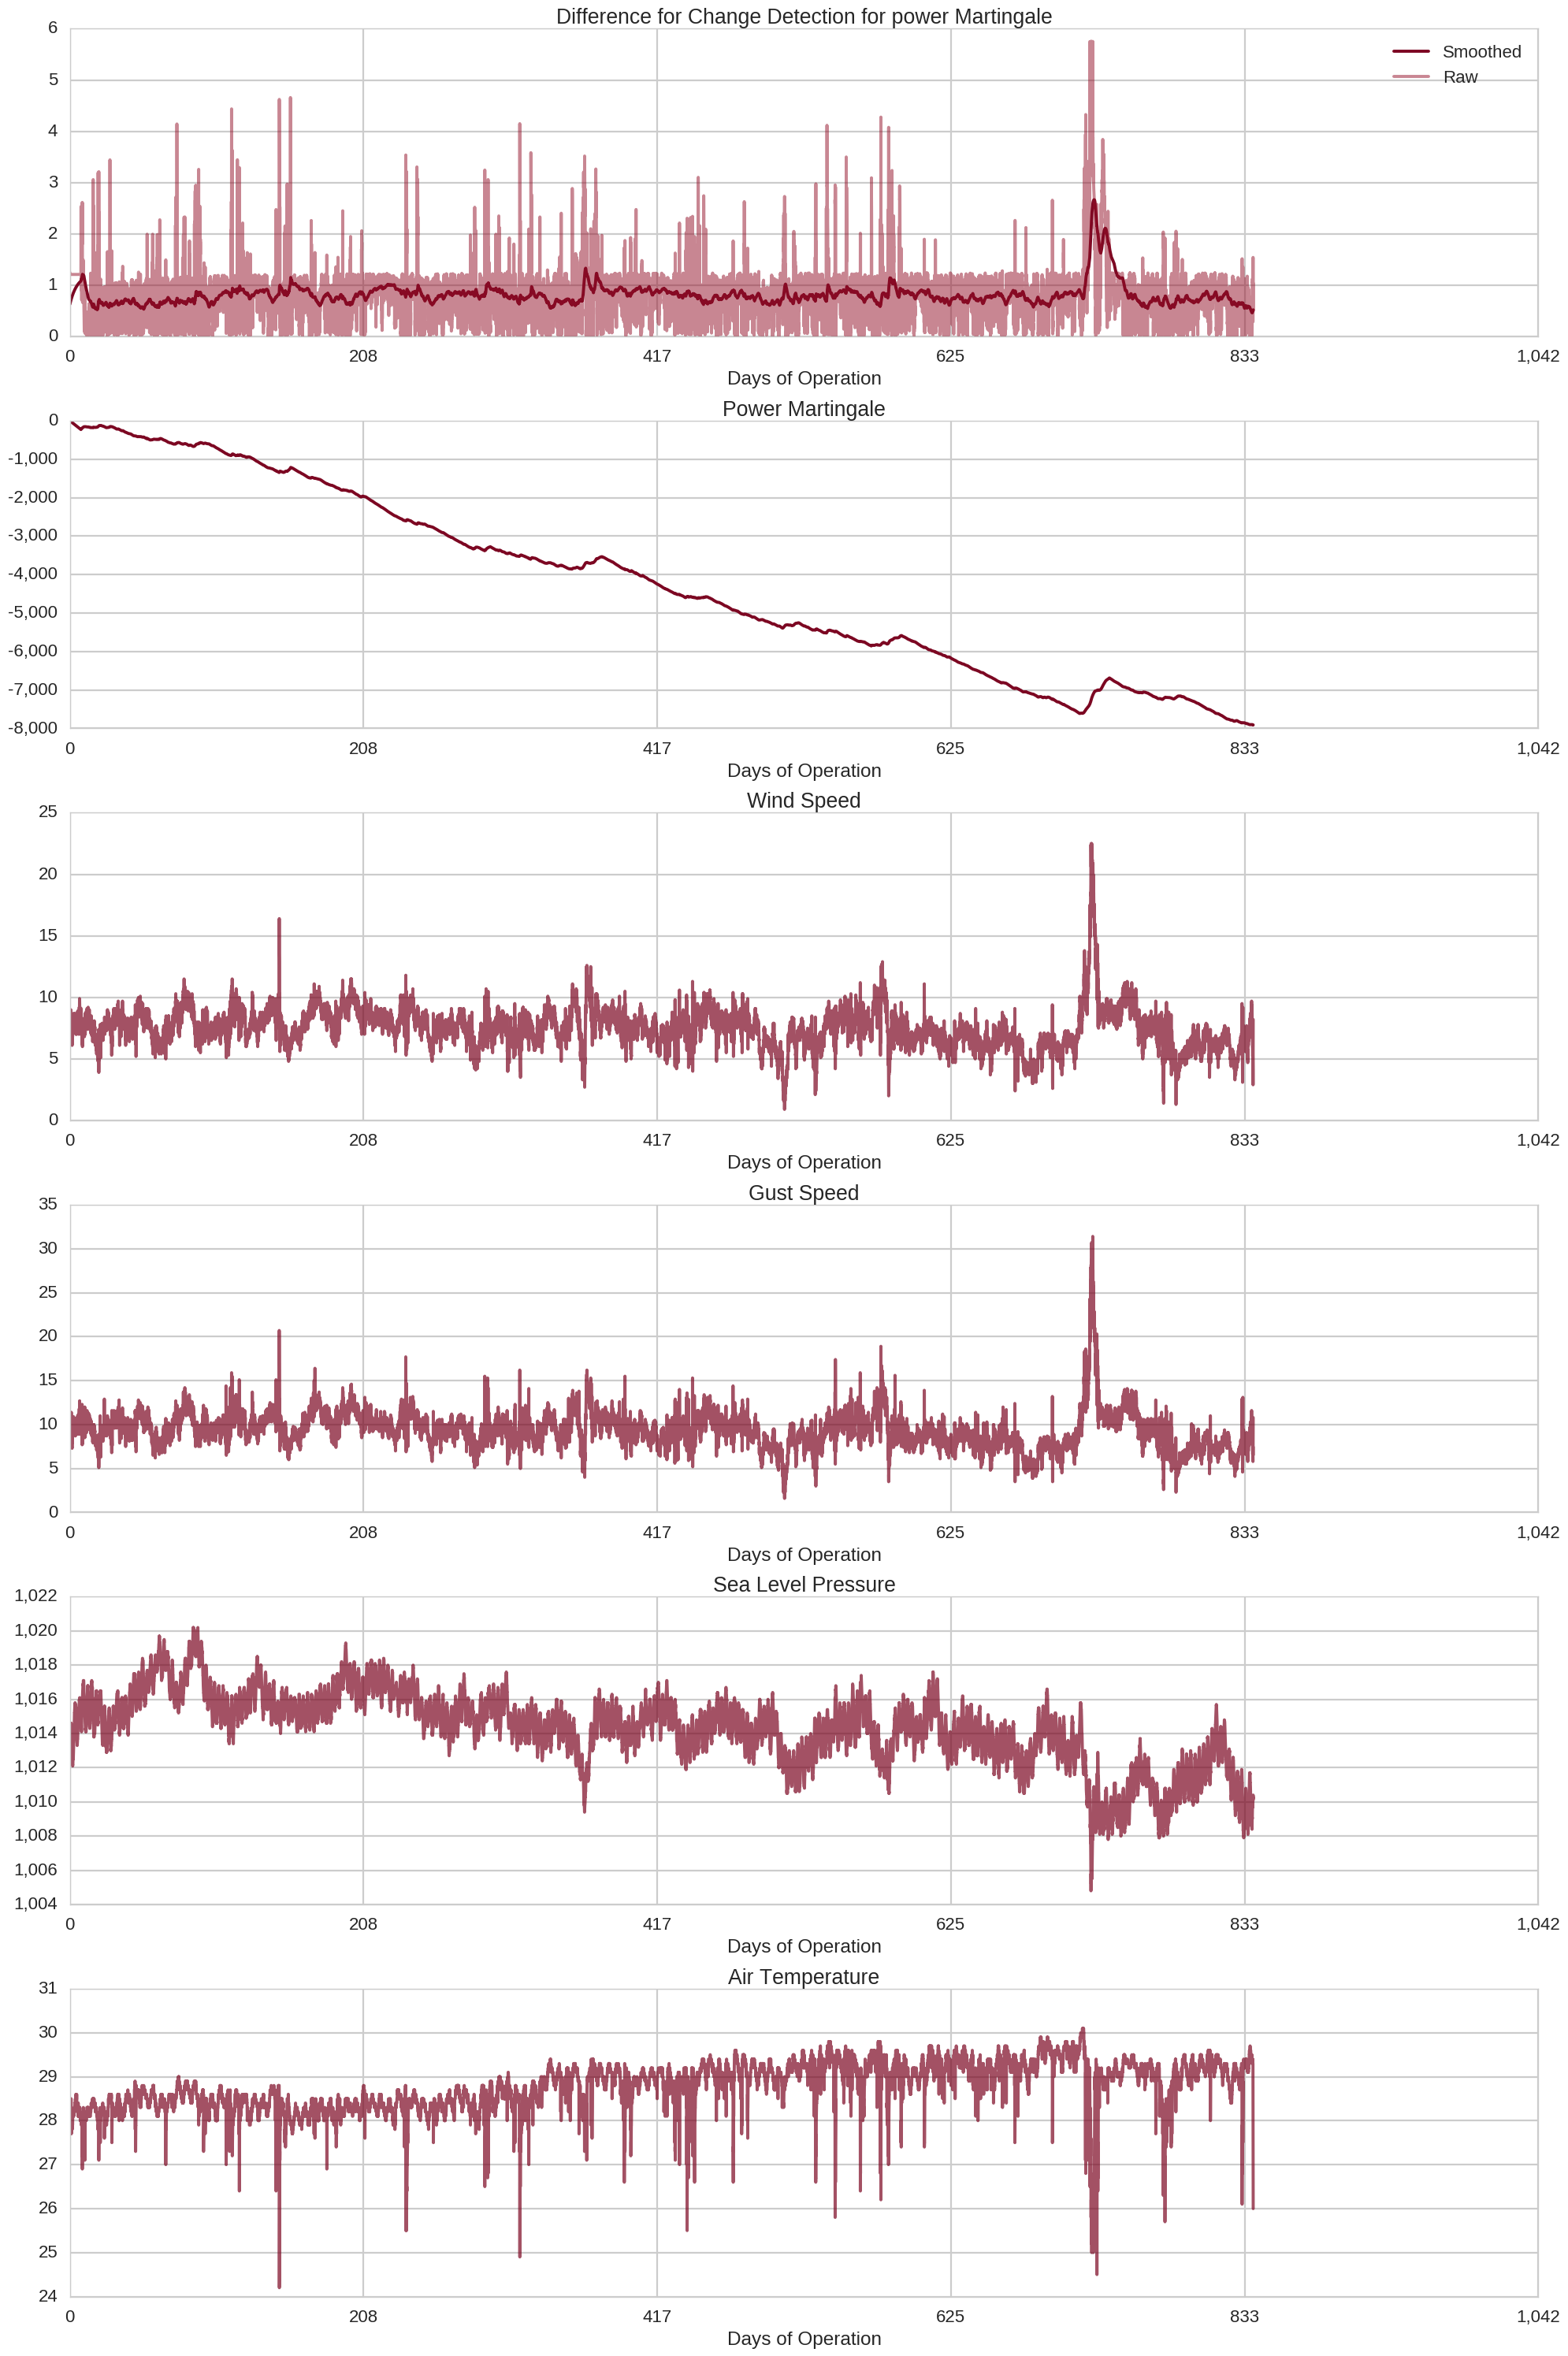

In [20]:
# Visualize the Difference Change Detection
# -----------------------------------------

fig = plt.figure(figsize = (20,30))

# number of subplots
nsp = data_clean.shape[1]

# Difference
ax1 = fig.add_subplot(nsp + 2, 1 , 1)
ax1.plot(smooth(diff2_pwr , a) , label= 'Smoothed')
ax1.plot(diff2_pwr , alpha = 0.5, label = 'Raw')
ax1.set_title('Difference for Change Detection for power Martingale')
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

# Processed data data
ax2 = fig.add_subplot(nsp + 2 , 1, 2)
ax2.plot(p_mar2_pwr)
ax2.set_title('Power Martingale')
ax2.set_xlabel('Time (june 2016 - October 2016)')
ax2.legend()
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

for i in range(nsp):
    ax = fig.add_subplot(nsp + 2, 1, i + 3)
    ax.plot(data_clean[:,i], alpha = 0.7)
    ax.set_title(get_name(title[i]))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
plt.tight_layout()
plt.show()


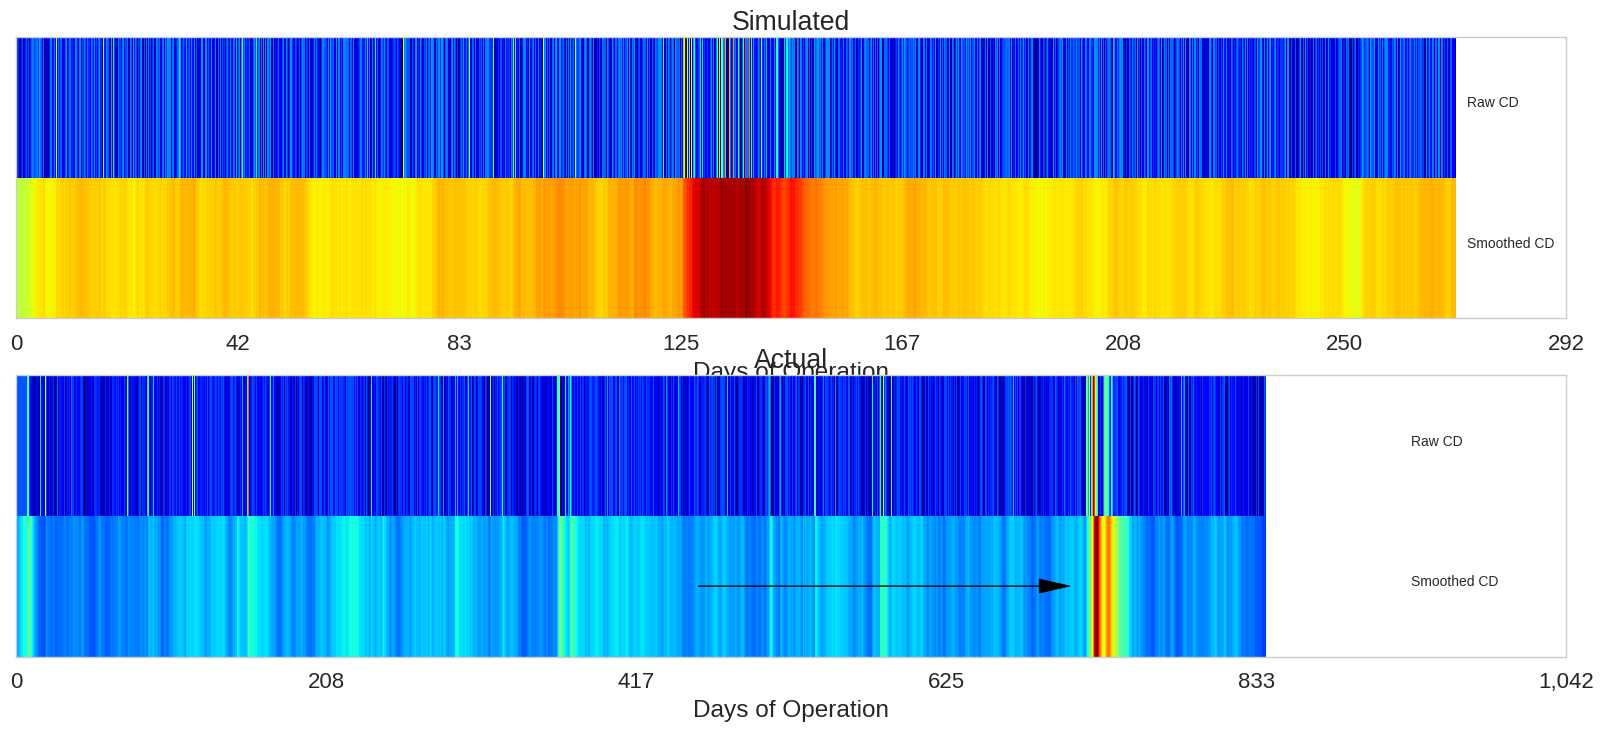

In [21]:
# visualize the heatmaps for the change detection (CD):
# ----------------------------------------------------

fig = plt.figure(figsize = (20,8))

#
ht1_pwr = heatmap_fil(diff1_pwr , a)
ax1 = fig.add_subplot(2,1,1)
ax1.text(6550,1,'Smoothed CD')
ax1.text(6550,3,'Raw CD')
ax1.set_title('Simulated')
ax1.pcolor(ht1_pwr , cmap = clr)
ax1.axes.get_yaxis().set_visible(False)
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

#
ht2_pwr = heatmap_fil(diff2_pwr , a)
ax2 = fig.add_subplot(2,1,2)
ax2.text(22500,1,'Smoothed CD')
ax2.text(22500,3,'Raw CD')
ax2.set_title('Actual')
ax2.pcolor(ht2_pwr , cmap = clr)
ax2.axes.get_yaxis().set_visible(False)
ax2.arrow(11000,1,5500,0, head_width=0.2, head_length=500, fc='k', ec='k')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

plt.show()

### 4.3- Power Martingale with Mixture

<br>

In [19]:
# Tune for delay:
#----------------

# Initiation of measure array
measure_mix = np.zeros((rows,))

# timer initiation
timer_2 = 0.

for i in range(rows):
    
    # start timer
    start_2 = time.time()
    
    # specify delay
    de = int(delay_array[i])
    
    # display progress
    display.clear_output(wait=True)
    display.display('Processing delay of ' + str(de) + ' at step ' + str(i + 1), 
                    'Process time : ' + str(timer_2) + ' sec')
        
    # evaluate the difference
    pmar, dif = power_martingale_mix(data_clean, resolution , de)
    dif_s = smooth(dif , a)
    
        
    # maximum data Matthew
    dif_max_m = np.max(dif_s[17000:18000])
    
        
    # Put in measure array (score)
    measure_mix[i] = (dif_max_m - np.average(dif_s)) / dif_s.std(axis=0)
    
    # stop timer
    timer_2 = time.time() - start_2


                   

'Processing delay of 500 at step 500'

'Process time : 11.5810000896 sec'

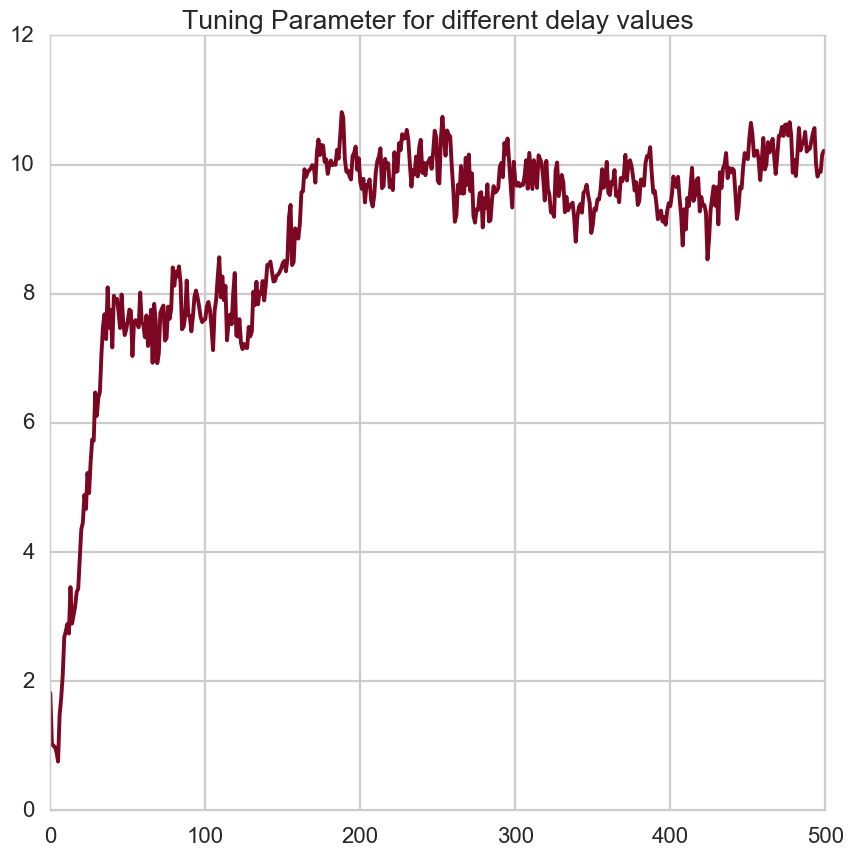

In [66]:
# Visualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.plot(measure_mix)
ax.set_title('Tuning Parameter for different delay values')

plt.show()

In [21]:
# Best Values
# -----------

best_de_mix = int(delay_array[np.argmax(measure_mix)])

print '\nBest Delay is : ' , best_de_mix


Best Delay is :  189


In [22]:
# Application and Visualization (Power Martingale with Mixture)
# -------------------------------------------------------------

# simulated data 
p_mar1_mix , diff1_mix = power_martingale_mix(sim_data,resolution , best_de_mix , sim = True)

# Filtered data
p_mar2_mix, diff2_mix = power_martingale_mix(data_clean,resolution , best_de_mix)

##

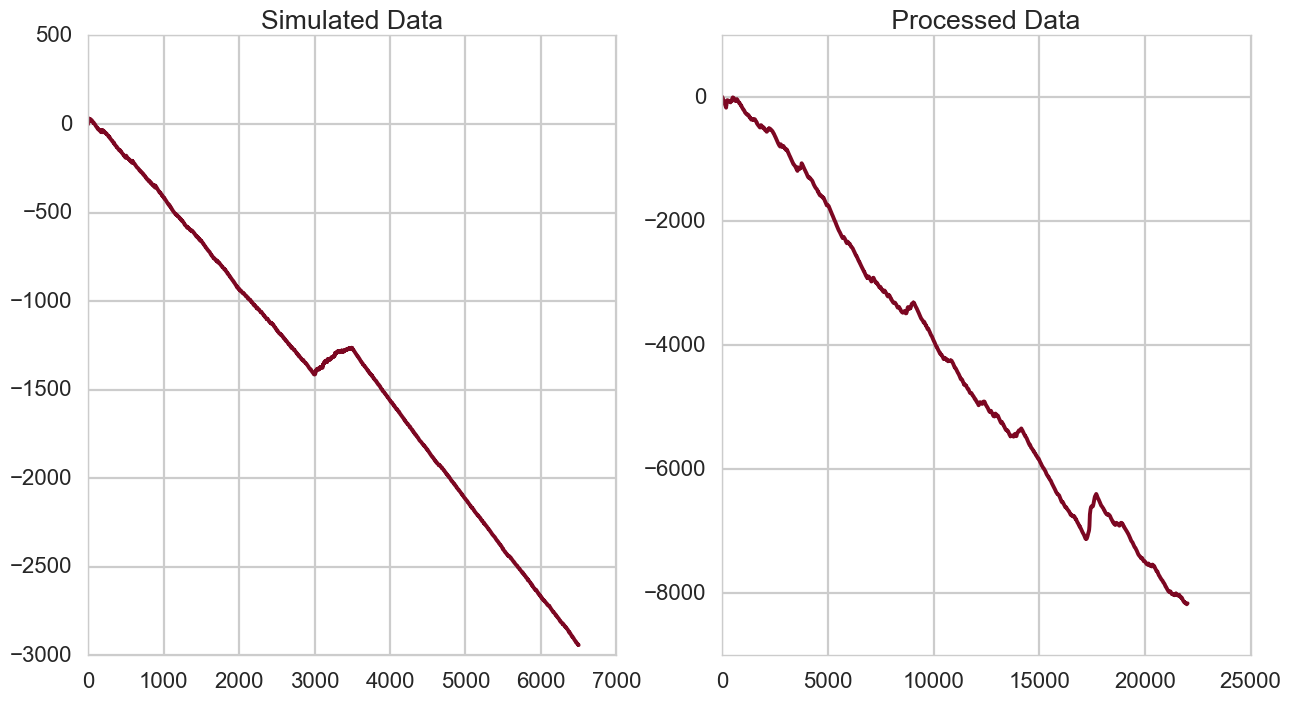

In [23]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_mix)
ax1.set_title('Simulated Data')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2_mix)
ax2.set_title(' Processed Data ')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.show()

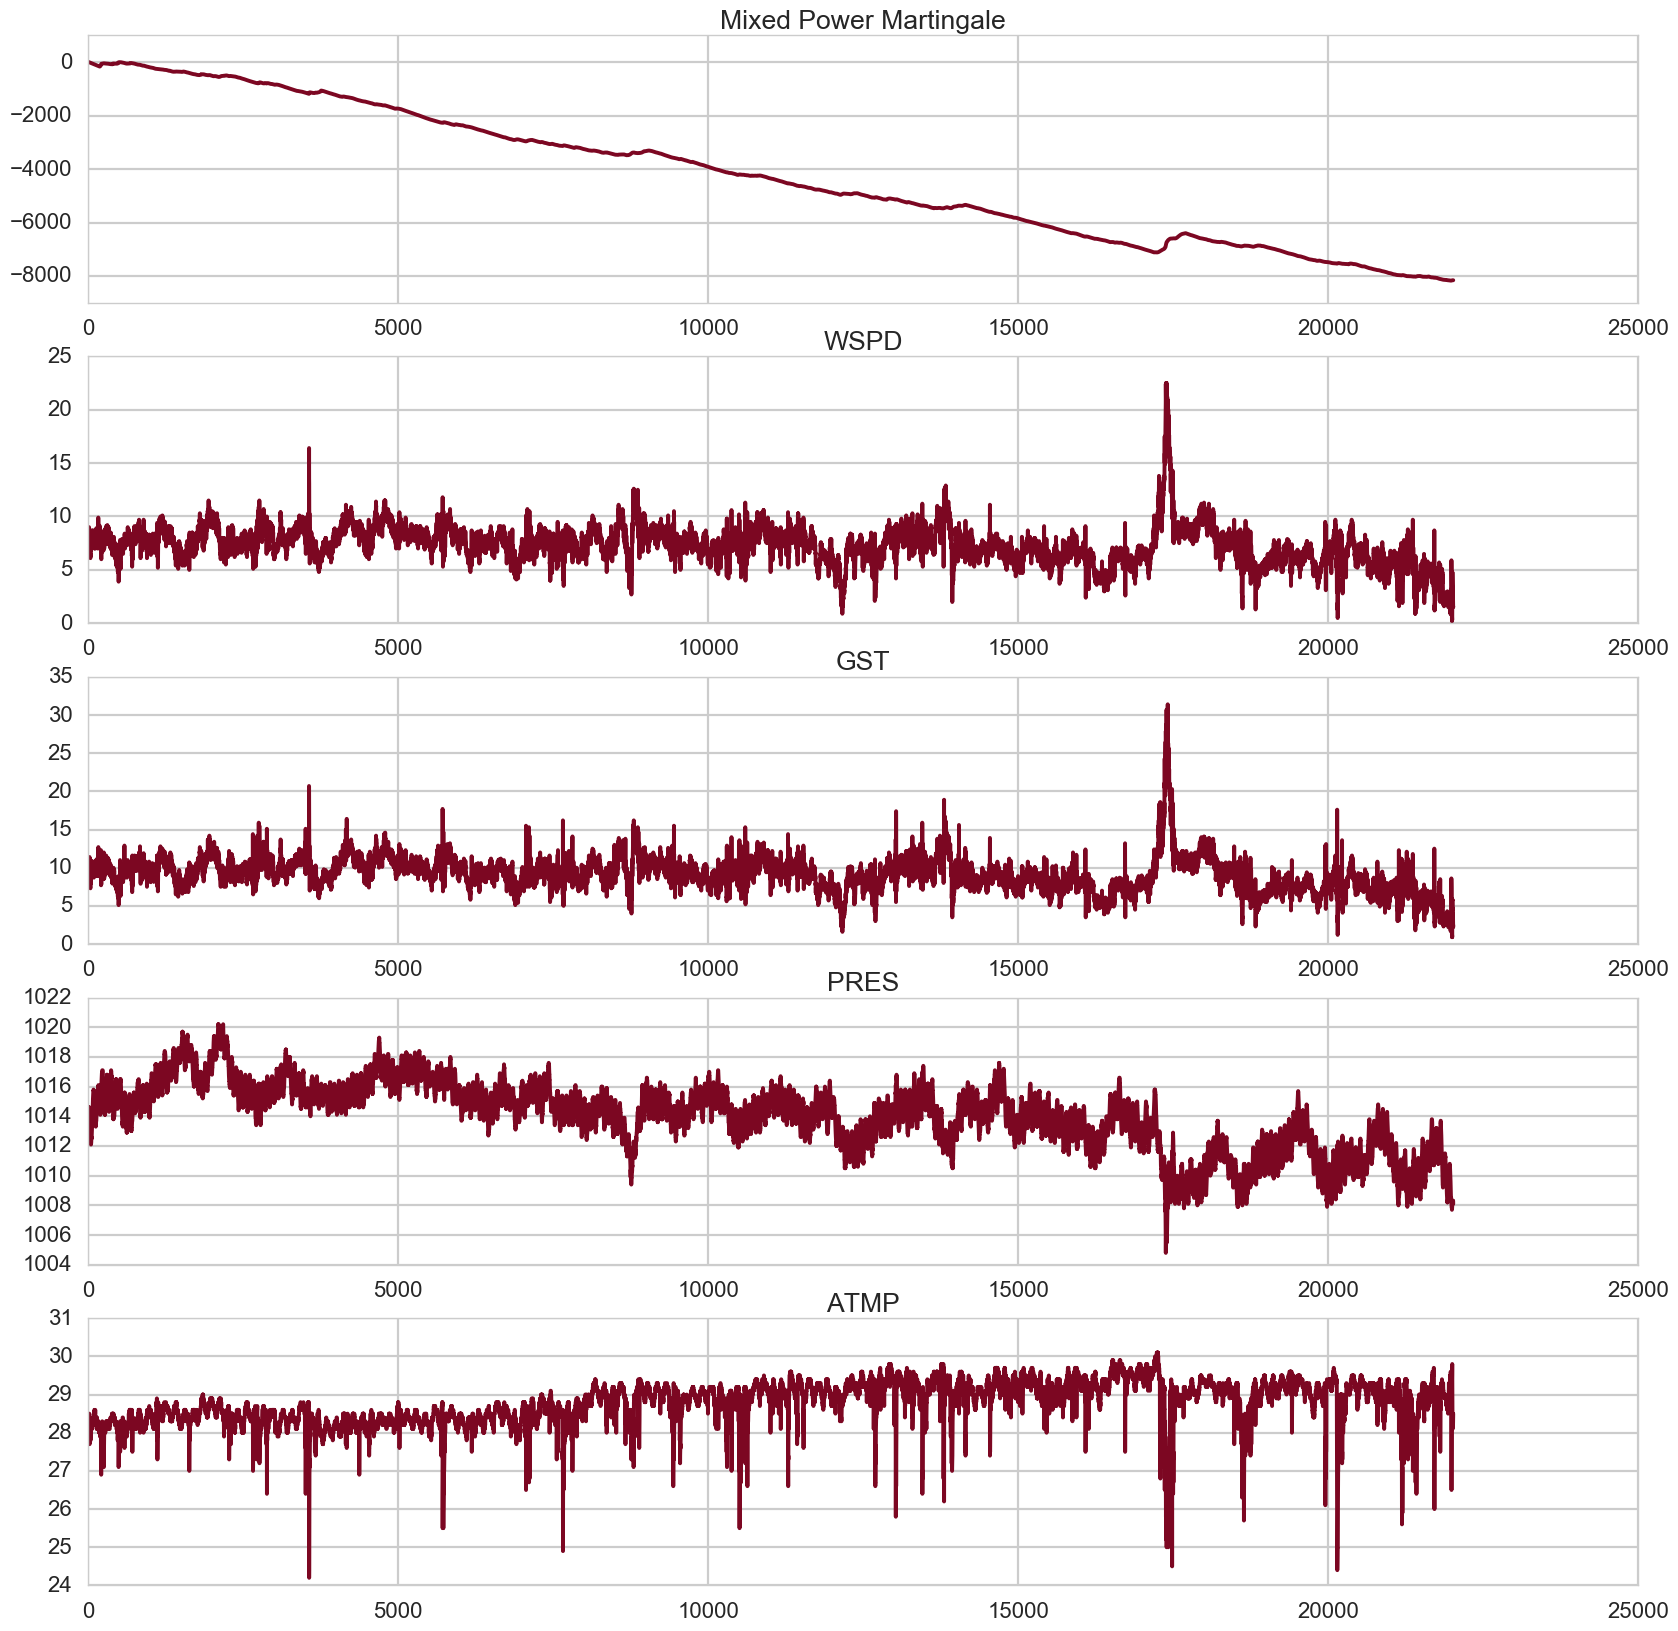

In [57]:
# Power Martingale Mix with raw data visualization
# ------------------------------------------------

fig = plt.figure(figsize = (20,20))

# number of subplots
nsp = data_clean.shape[1]

# Martingale
ax1 = fig.add_subplot(nsp+1 , 1 , 1)
ax1.plot(p_mar2_mix)
ax1.set_title('Mixed Power Martingale')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

for i in range(nsp):
    ax = fig.add_subplot(nsp + 1, 1, i + 2)
    ax.plot(data_clean[:,i])
    ax.set_title(get_name(title[i]))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')

plt.tight_layout()
plt.show()

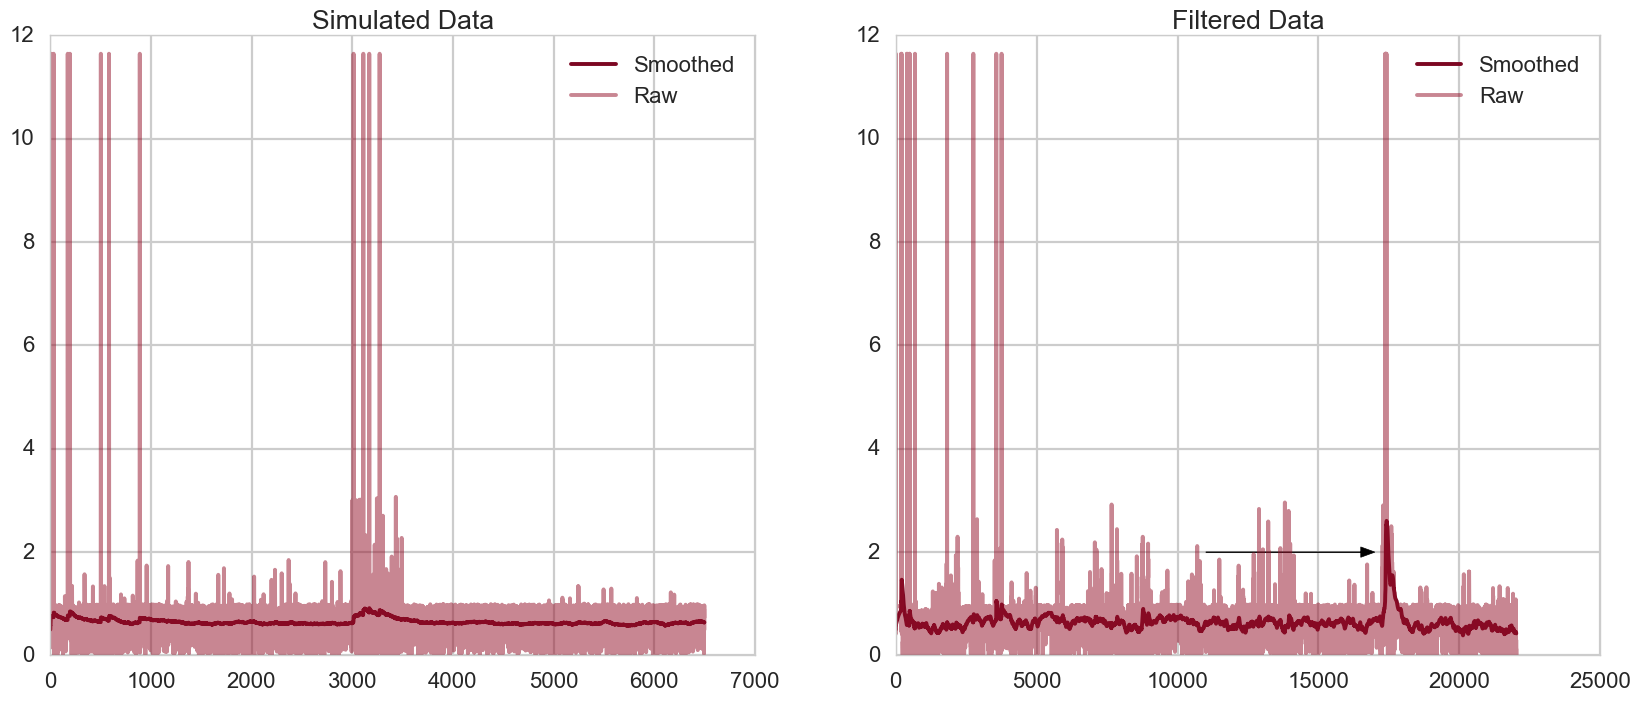

In [24]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,20))

# Simulated Data
ax1 = fig.add_subplot(221)
ax1.plot(smooth(diff1_mix , a) ,  label = 'Smoothed')
ax1.plot(diff1_mix , alpha = 0.5 , label = 'Raw')
ax1.set_title('Simulated Data')
ax1.legend()
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

# Processed data
ax2 = fig.add_subplot(222)
ax2.plot(smooth(diff2_mix , a) , label = 'Smoothed' )
ax2.plot(diff2_mix , alpha = 0.5 , label = 'Raw')
ax2.set_title('Filtered Data')
ax2.legend()
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

#Martingale for simulated data

plt.show()

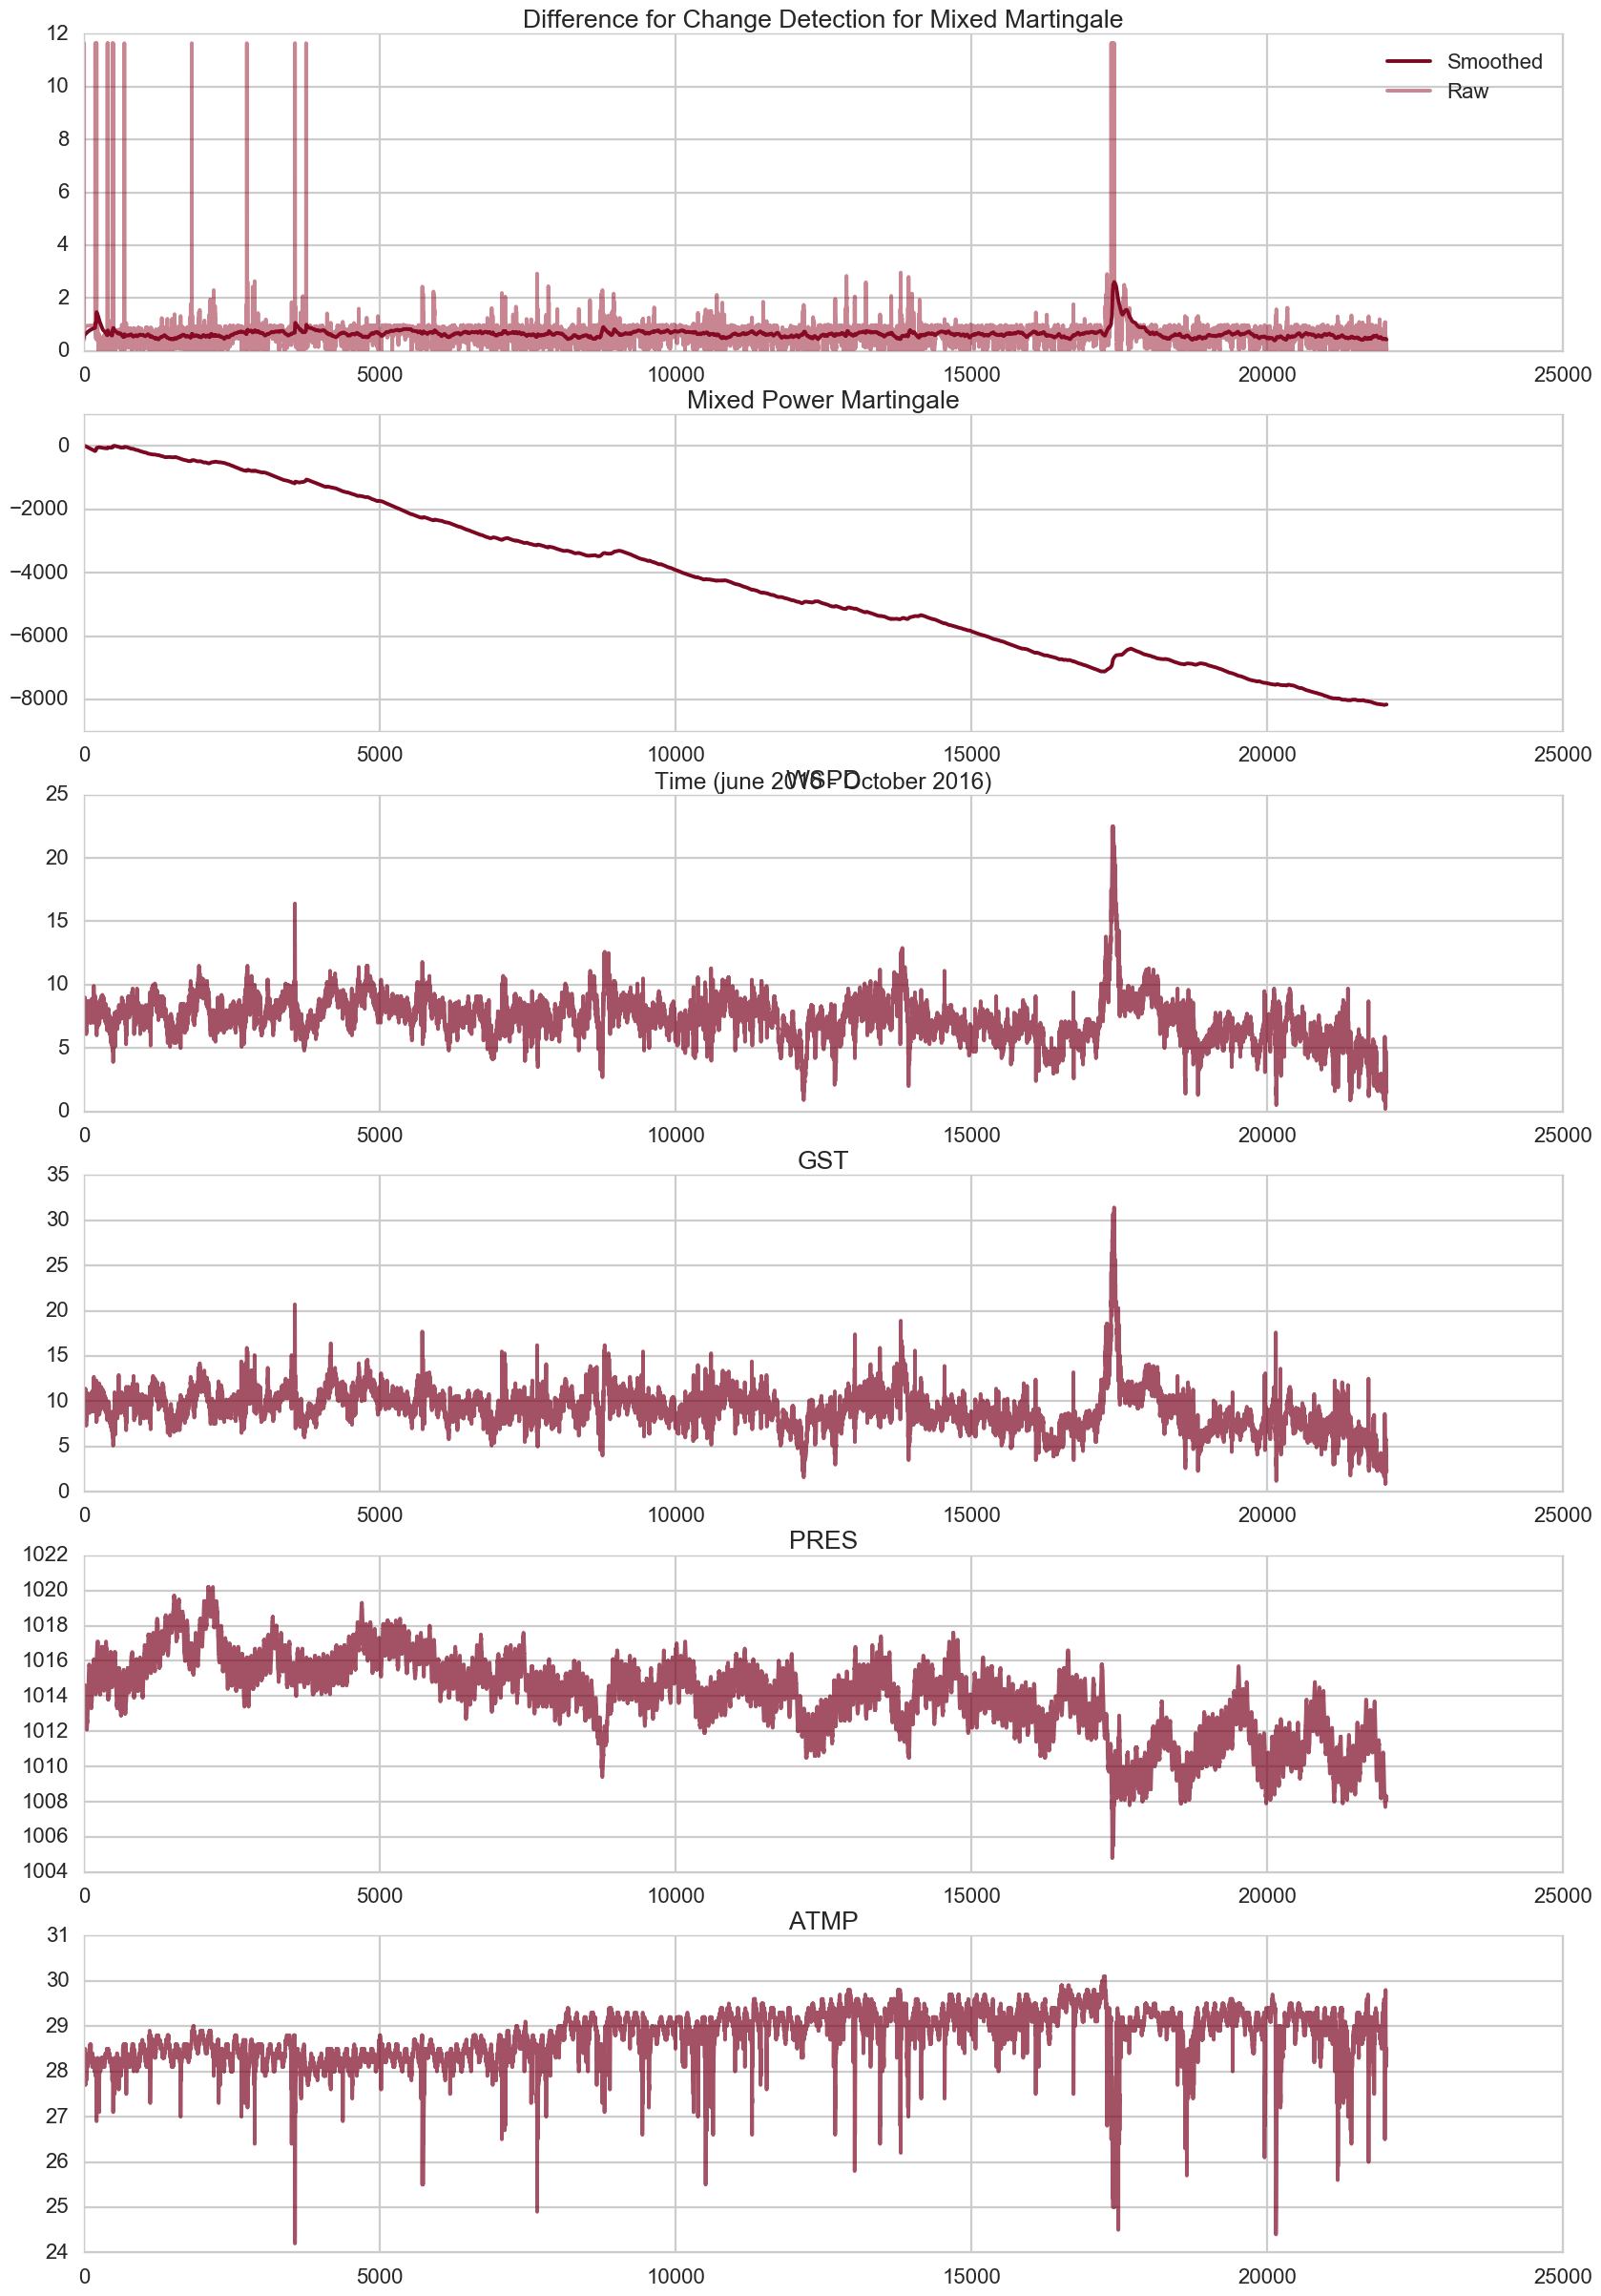

In [75]:
# Visualize the Difference Change Detection
# -----------------------------------------

fig = plt.figure(figsize = (20,30))

# number of subplots
nsp = data_clean.shape[1]

# Difference
ax1 = fig.add_subplot(nsp + 2, 1 , 1)
ax1.plot(smooth(diff2_mix , a) , label= 'Smoothed')
ax1.plot(diff2_mix , alpha = 0.5, label = 'Raw')
ax1.set_title('Difference for Change Detection for Mixed Martingale')
ax1.legend()
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

# Processed data data
ax2 = fig.add_subplot(nsp + 2 , 1, 2)
ax2.plot(p_mar2_mix)
ax2.set_title('Mixed Power Martingale')
ax2.set_xlabel('Time (june 2016 - October 2016)')
ax2.legend()
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

for i in range(nsp):
    ax = fig.add_subplot(nsp + 2, 1, i + 3)
    ax.plot(data_clean[:,i] , alpha = 0.7)
    ax.set_title(get_name(title[i]))
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
plt.tight_layout()
plt.show()

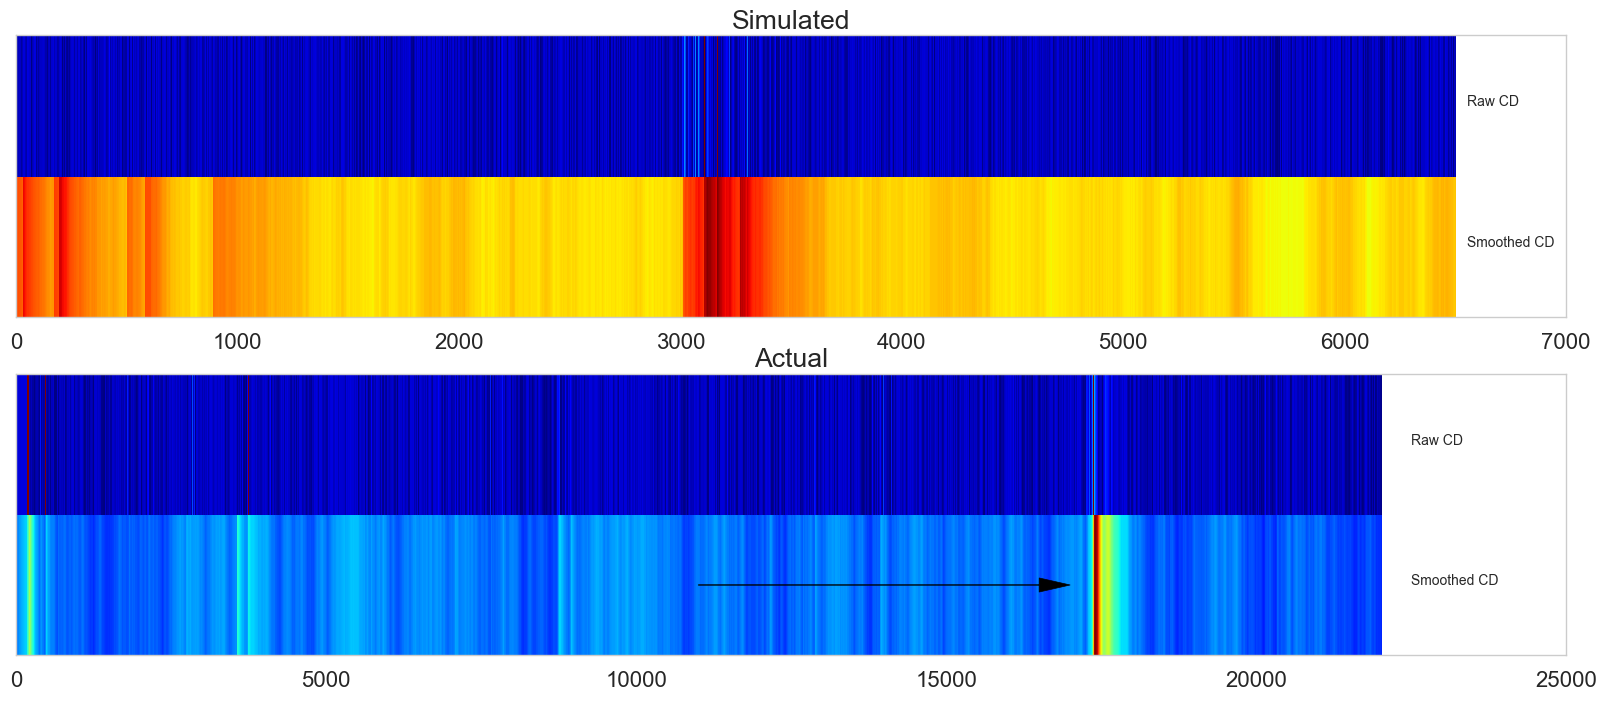

In [25]:
# visualize the heatmaps for the change detection (CD):
# -----------------------------------------------------

fig = plt.figure(figsize = (20,8))

#
ht1_mix = heatmap_fil(diff1_mix , a)
ax1 = fig.add_subplot(2,1,1)
ax1.pcolor(ht1_mix , cmap = clr)
ax1.text(6550,1,'Smoothed CD')
ax1.text(6550,3,'Raw CD')
ax1.set_title('Simulated')
ax1.axes.get_yaxis().set_visible(False)
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

#
ht2_mix = heatmap_fil(diff2_mix , a)
ax2 = fig.add_subplot(2,1,2)
ax2.pcolor(ht2_mix , cmap = clr)
ax2.text(22500,1,'Smoothed CD')
ax2.text(22500,3,'Raw CD')
ax2.set_title('Actual')
ax2.axes.get_yaxis().set_visible(False)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

plt.show()

## 5.0 Summary of two methods

<br>

### 5.1- Processed Data Plot

<br>
**Data after normalization and applying the best delay difference**

<br>

In [26]:
# Preprocess the data with normalization and applying best delay difference:
# --------------------------------------------------------------------------

# Select best delay to apply
best_de = best_de_pwr

# Normalization
data_preproc = data_clean / np.std(data_clean, axis = 0)
    
# initiate Filtered data
data_preproc_filtered = np.zeros(data_preproc.shape)
    
# delay-Filter
for i in range (best_de, data_preproc.shape[0]):
    data_preproc_filtered[i, :] = data_preproc[i,:] - data_preproc[ i - best_de , : ]

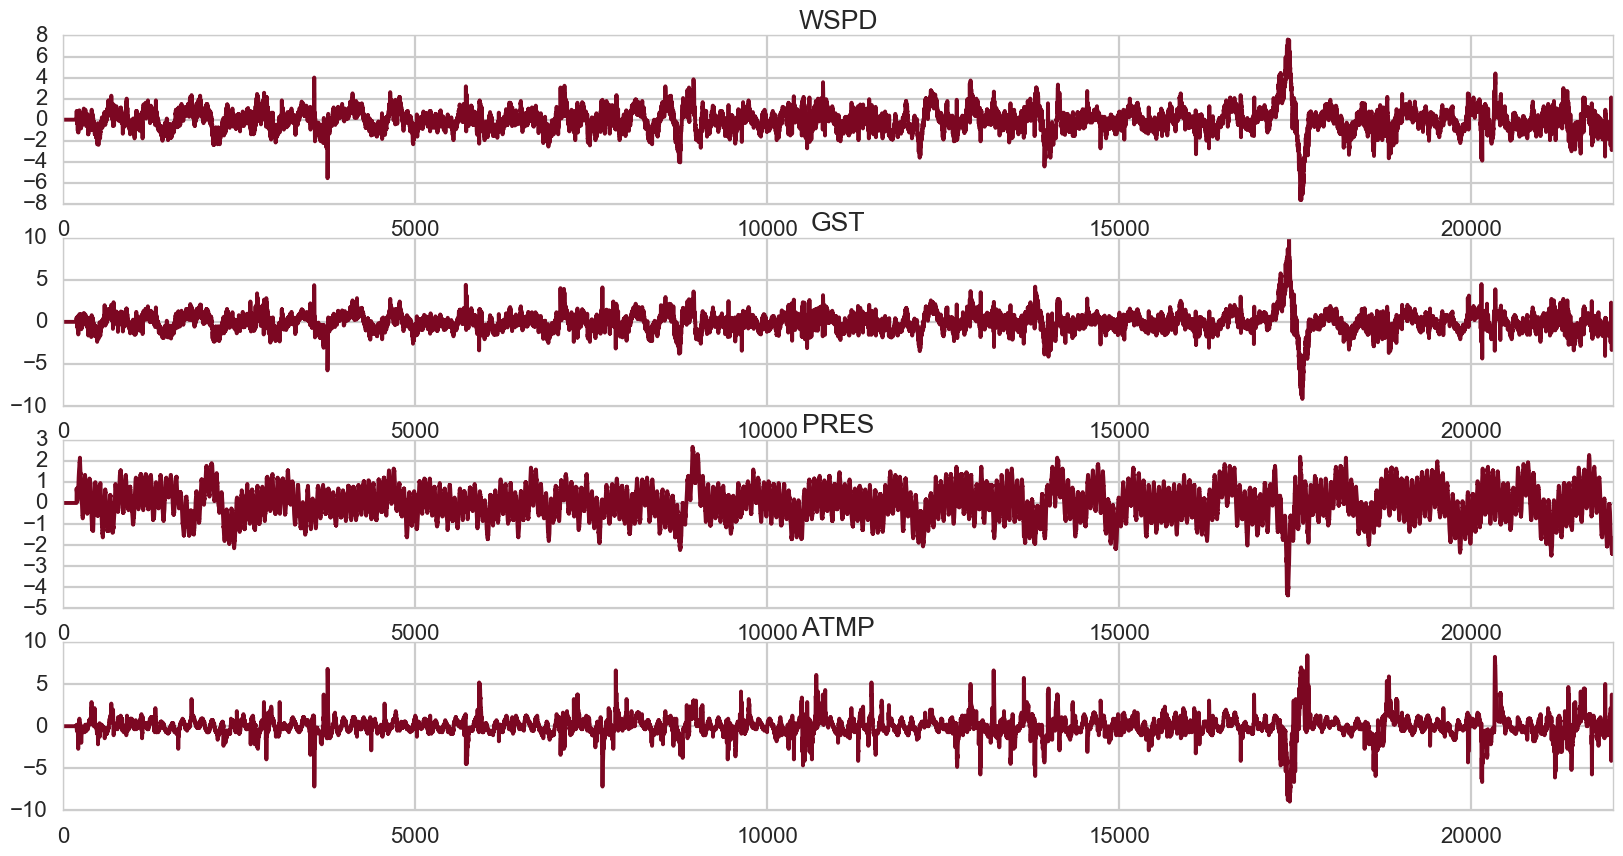

In [27]:
# Visualize the preprocessed data:
# --------------------------------

fig = plt.figure(figsize = (20, 10))
n = data_preproc_filtered.shape[1]

# iterrate for data columns
for i in range (n):
    ax = fig.add_subplot(n,1,i + 1)
    ax.plot(data_preproc_filtered[:,i])
    ax.set_title(get_name(title[i]))
    ax.set_xlim(0, L)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
    vals = ax1.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
    
plt.show()

### 5.2- Power and Mix Martingale Plots

<br>

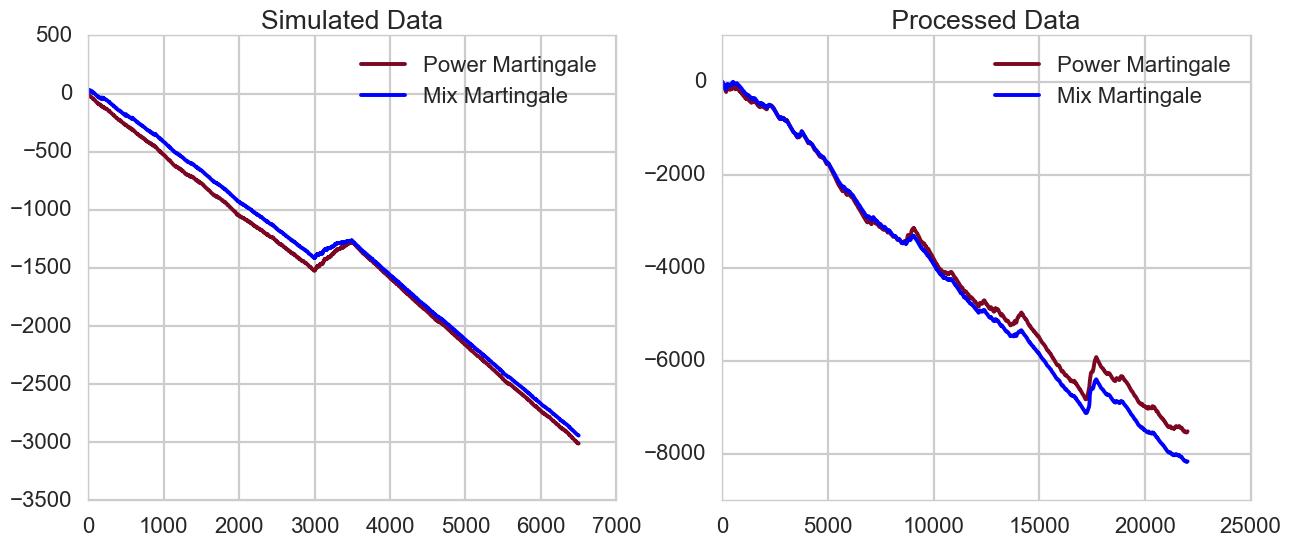

In [28]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,6))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_pwr , label = 'Power Martingale')
ax1.plot(p_mar1_mix , 'b' , label = 'Mix Martingale')
ax1.set_title('Simulated Data')
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2_pwr , label = 'Power Martingale')
ax2.plot(p_mar2_mix , 'b' , label = 'Mix Martingale')
ax2.set_title(' Processed Data ')
ax2.legend()
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

plt.show()

### 5.3- Change Detection Plots

<br>

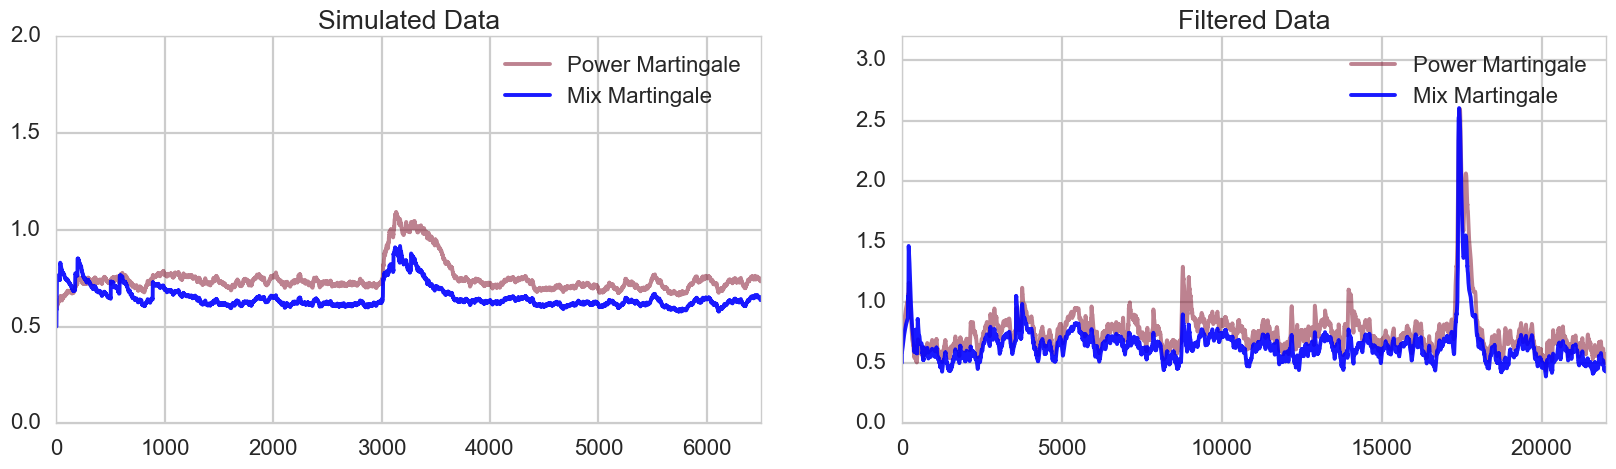

In [29]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,5))

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1_pwr , a) , label = 'Power Martingale', alpha = 0.5)
ax1.plot(smooth(diff1_mix , a) , 'b' , label = 'Mix Martingale' , alpha = 0.9)
ax1.set_title('Simulated Data')
ax1.set_xlim(0, diff1_pwr.shape[0])
ax1.set_ylim(0, 2)
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2_pwr , a) , label = 'Power Martingale', alpha = 0.5)
ax2.plot(smooth(diff2_mix , a) , 'b' , label = 'Mix Martingale' , alpha = 0.9)
ax2.set_title('Filtered Data')
ax2.set_xlim(0, diff2_pwr.shape[0])
ax2.set_ylim(0, 3.2)
ax2.legend()
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

plt.show()

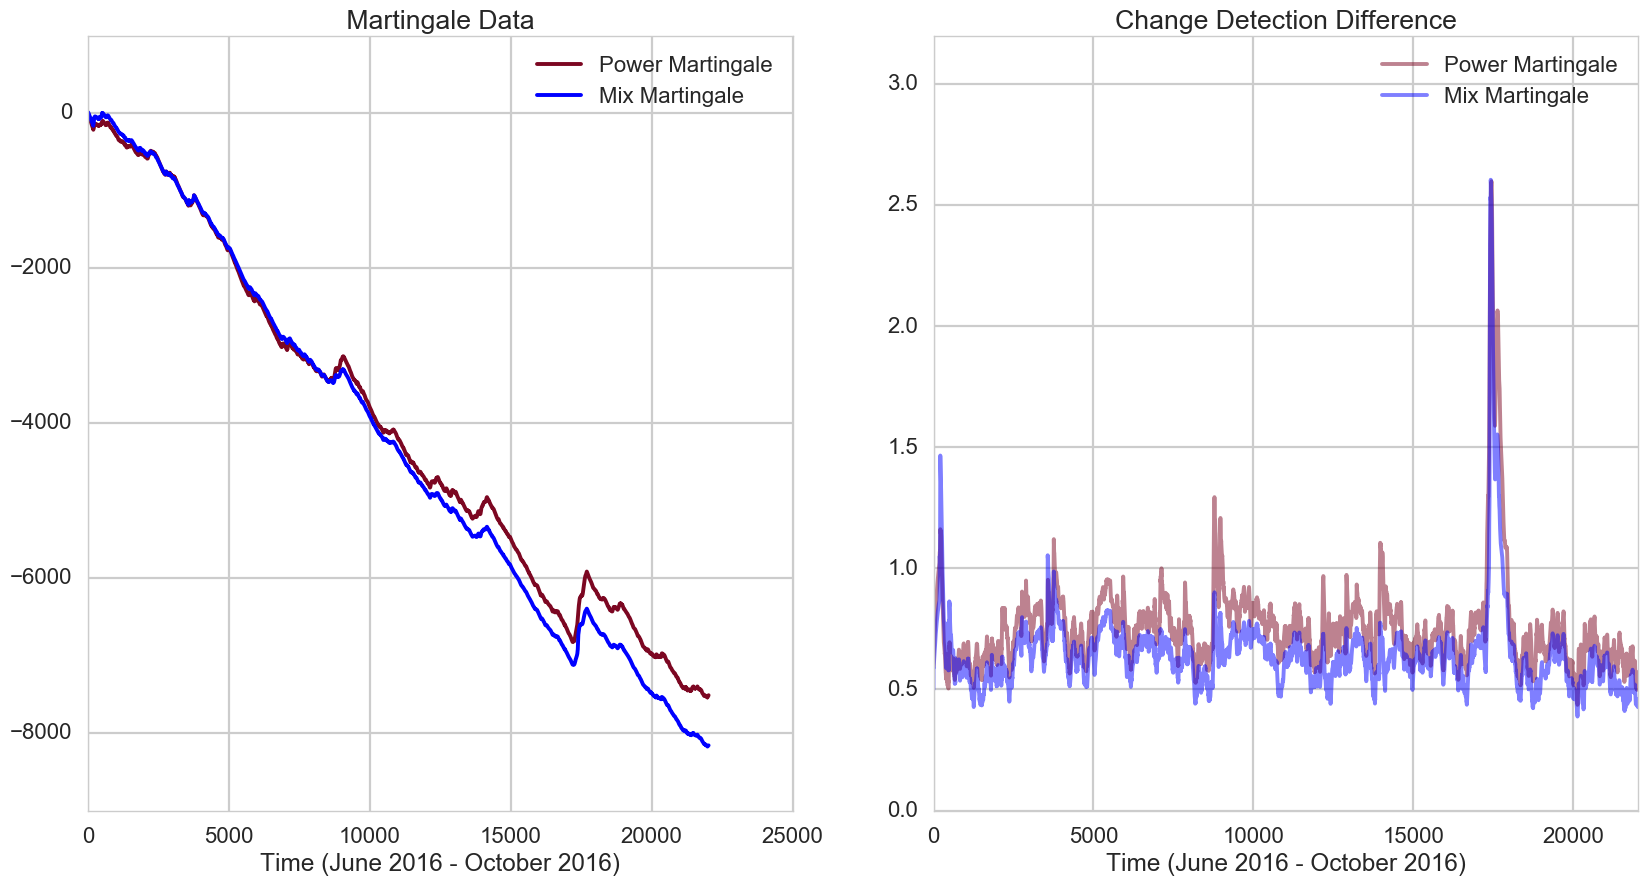

In [65]:
# Visualize for Matthew Tuning:
# ----------------------------

# plot initialization
fig = plt.figure(figsize = (20,10))

# plot Martingales
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar2_pwr , label = 'Power Martingale')
ax1.plot(p_mar2_mix , 'b' , label = 'Mix Martingale')
ax1.set_title(' Martingale Data ')
ax1.set_xlabel('Days of Operation (June 2016 - October 2016)')
ax1.legend()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])


# Change DetectionDifference
ax2 = fig.add_subplot(1,2,2)
ax2.plot(smooth(diff2_pwr , a) , label = 'Power Martingale', alpha = 0.5)
ax2.plot(smooth(diff2_mix , a) , 'b' , label = 'Mix Martingale' , alpha = 0.5)
ax2.set_title('Change Detection Difference')
ax2.set_xlim(0, diff2_pwr.shape[0])
ax2.set_xlabel('Days of Operation (June 2016 - October 2016)')
ax2.set_ylim(0, 3.2)
ax2.legend()
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])


plt.show()

### 5.4- Heatmap Plots


In [30]:
# Comparitive heatmap array
# -------------------------
    
# apply smoothing
xk1 = smooth(diff2_pwr , a)
xk2 = smooth(diff2_mix , a)
    
# reshape arrays
x1 = xk1.reshape((1,L)) 
x2 = xk2.reshape((1,L)) 
    
# Augment arrays
ext1 = np.concatenate((x1 , x1) , axis = 0)
ext2 = np.concatenate((x2 , x2) , axis = 0)
    
# Join arrays
ext = np.concatenate((ext1 , ext2) , axis = 0)

        

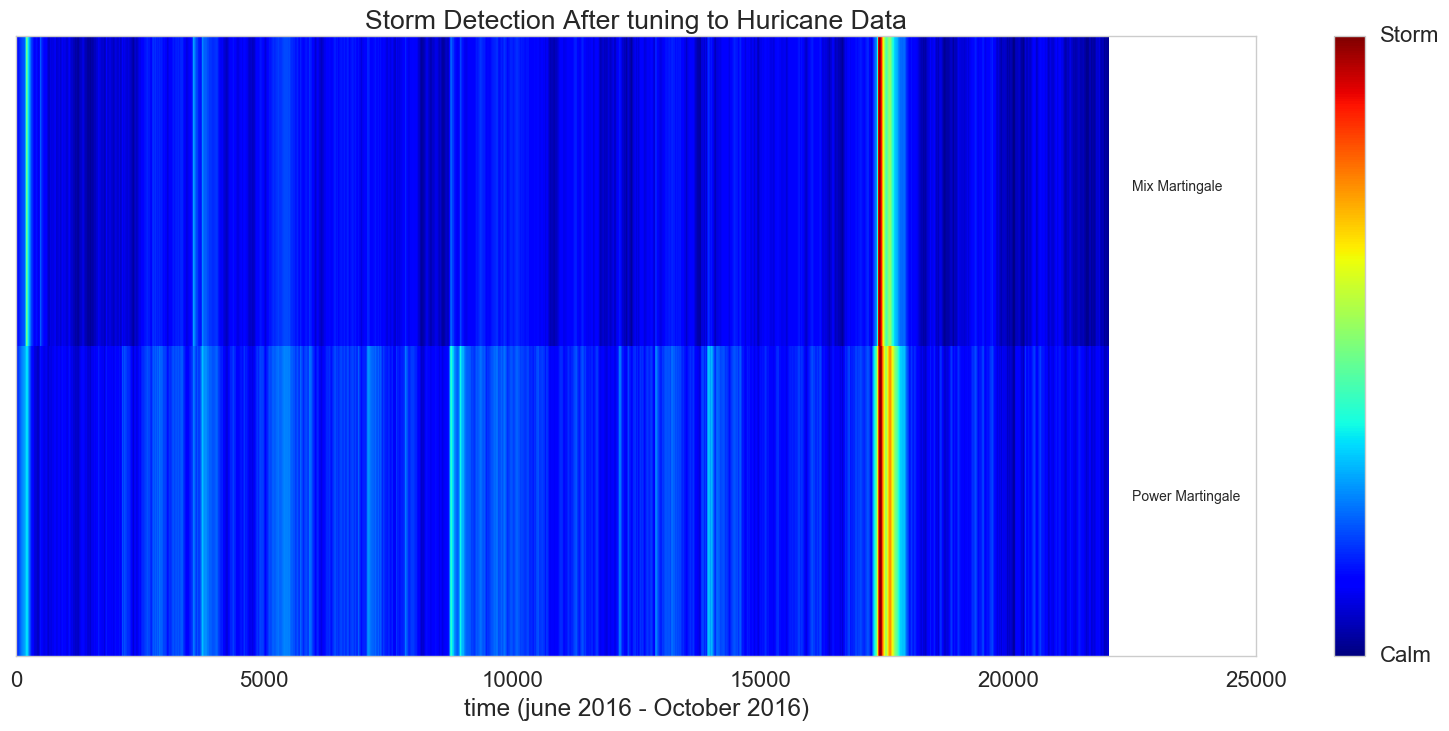

In [45]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (20,8))

#
ax = fig.add_subplot(1,1,1)
cax = ax.pcolor(ext , cmap = clr)
cbar = fig.colorbar(cax , ticks = [ext.min() , ext.max()])
cbar.ax.set_yticklabels(['Calm' , 'Storm'])
ax.text(22500,1,'Power Martingale')
ax.text(22500,3,'Mix Martingale')
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel('Days of Operation (June 2016 - October 2016)')
ax.set_title('Storm Detection After tuning to Huricane Data')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])



plt.show()

### 5.5- Conclusion

<br>
** Based on the above, the following can be concluded:**

<br>
 - Best delay for step difference filter is 189
 - Best epsilon value is 0.307
 - The mix martingale gives more consistent result with epsilon ranges between 0.001 and 0.999
 
<br>

---